In [1]:
# Modify the file A00_setup.  Note the working directory is changed
import os
os.chdir(os.getcwd().rsplit(os.path.sep + 'code')[0] + os.path.sep + 'code')
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./A_target_count_encoding/A00_setup.py").load_module()
os.getcwd()

'/Users/valeriecarey/Documents/projects/2023_10_blog_gnn_sba/code'

# XGBoost, Target-Thresh: Vary threshold
No blending of hierarchy, and instead of shrinking towards the mean, low volume codes are set to NA values. 

*This script takes about 5 minutes on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
import pickle

In [3]:
from pathlib import Path

In [4]:
import sklearn as sk
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance, partial_dependence
from scikitplot.metrics import plot_lift_curve

In [5]:
from sba_gnn.sba_gnn import sg_plot, sg_target_count_encoder
from sba_gnn.sba_gnn.sg_target_thresh_encoder import TargetThreshEncoder

## Import Processed Datasets

In [6]:
sba_loans = pd.read_parquet(Path(setup.parent_path).joinpath('01_DATA_transformed.parquet')) 

In [7]:
best_params_df = pd.read_csv(Path(setup.parent_path).joinpath('03_REPORT_fit_parameter_selected.csv'))
best_params = best_params_df.to_dict(orient='records')[0]
best_params

{'subsample': 0.8,
 'scale_pos_weight': 1.0,
 'reg_lambda': 0.01,
 'reg_alpha': 0.001,
 'min_child_weight': 50,
 'max_depth': 8,
 'learning_rate': 0.1,
 'gamma': 2}

In [8]:
xgb_params = dict(best_params, 
                   **{'objective':"binary:logistic", 'n_estimators':setup.xgb_n_estimators})

In [9]:
train_counts = pd.read_parquet(Path(setup.temp_path).joinpath('A60_DATA_train_counting.parquet')) 

##### Comparison metrics

In [10]:
metrics_base = pd.read_csv(Path(setup.temp_path).joinpath('A61_REPORT_metrics.csv'))
metrics_tc = pd.read_csv(Path(setup.temp_path).joinpath('A62_REPORT_metrics.csv'))

In [11]:
# Standard target encoding
metrics_tenc = pd.read_csv(Path(setup.temp_path).joinpath('A60_REPORT_metrics.csv'))

## Function to get metrics

In [12]:
def get_metrics(data, threshold = 100, enc_features = ['NAICS', 'NAICS_sector']):
    
    # Alternative encoding
    train_df = data[data['dset'] == 'train']
    enc_dict = {f:TargetThreshEncoder(threshold = threshold) for f in enc_features}
    [enc_dict[f].fit(train_df[f], train_df['target']) for f in enc_features]
    enc_val = pd.concat([enc_dict[f].transform(data[f]) for f in enc_features],
                    axis=1, keys=enc_features)
    enc_val.columns = [c[0] + '_' + c[1] for c in enc_val.columns]
    
    # Append to data
    data = pd.concat([data.drop(columns=enc_val.columns, errors='ignore'), enc_val], 
                      axis=1)
    train_df = data[data['dset'] == 'train']
    test_df = data[data['dset'] == 'test']
    val_df = data[data['dset'] == 'val']
    
    # Remove low volume codes from train only
    counts_thresh = train_counts[train_counts['count'] > threshold][['NAICS']]
    train_df = train_df.merge(counts_thresh, on='NAICS')
    
    predictor_features = setup.predictor_features + list(enc_val.columns)

    # Model fit
    xgb_model = xgb.XGBClassifier(objective="binary:logistic",
                             n_estimators =  setup.xgb_n_estimators)
    xgb_model = xgb_model.set_params(**xgb_params)
    xgb_model.fit(train_df[predictor_features], train_df['target'],
              eval_set = [(train_df[predictor_features], train_df['target']),
                         (val_df[predictor_features], val_df['target'])])
    
    # Predict
    pred_df = pd.concat([data[['LoanNr_ChkDgt', 'dset', 'target', 'dset_naics_holdout']].reset_index(),
                     pd.DataFrame({'predict_prob':
                                   xgb_model.predict_proba(data[predictor_features])[:,1]})],
                    axis=1) \
    .set_index('index')
    
    # Decision threshold
    pred_train_df = pred_df[pred_df['dset'] == 'train']
    thresh_tune_data = sg_plot.get_f1_frame(pred_train_df['target'], 
                                        pred_train_df['predict_prob'])
    thresh_head = thresh_tune_data.sort_values('f1', ascending=False).head(2)
    best_thresh = thresh_head['thresh'].iloc[0]
    pred_df['predict_bin'] = np.where(pred_df['predict_prob'] >= best_thresh, 1, 0)
    
    # Metrics
    metrics_dset_df = pred_df.groupby('dset') \
        .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
        .reset_index()
    metrics_test_df = pred_df[pred_df['dset'] == 'test'] \
        .groupby(['dset', 'dset_naics_holdout']) \
        .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
        .reset_index()
    metrics_df = pd.concat([metrics_dset_df, metrics_test_df])
    
    return pred_df, metrics_df

## Loop to get predictions, metrics

In [13]:
count_sets = [5, 10, 20, 50, 100, 200, 500, 1000, 2000]

In [14]:
%%capture
pred_df = pd.DataFrame()
metrics_df = pd.DataFrame()
for c in count_sets:
    this_pred, this_met = get_metrics(sba_loans, c, 
                                     ['NAICS', 'NAICS_5', 'NAICS_4', 'NAICS_3', 'NAICS_sector'])
    this_pred['c'] = c
    pred_df = pd.concat([pred_df, this_pred])
    this_met['c'] = c
    metrics_df = pd.concat([metrics_df, this_met])

In [15]:
metrics_df[metrics_df['dset_naics_holdout'] == 1]

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout,c
1,test,0.527516,0.401767,0.260915,0.873107,0.334748,0.721906,1.0,5
1,test,0.532928,0.404586,0.263281,0.873276,0.323587,0.716256,1.0,10
1,test,0.517955,0.399318,0.258104,0.881736,0.330369,0.720857,1.0,20
1,test,0.514050,0.398462,0.257052,0.885712,0.329855,0.718341,1.0,50
1,test,0.529945,0.402026,0.261452,0.869554,0.331248,0.721434,1.0,100
1,test,0.528762,0.402867,0.261691,0.874799,0.330782,0.722798,1.0,200
1,test,0.534480,0.402949,0.262699,0.864478,0.328313,0.717243,1.0,500
1,test,0.551513,0.408227,0.268490,0.851282,0.333138,0.721639,1.0,1000
1,test,0.563088,0.410038,0.271682,0.835547,0.334631,0.720202,1.0,2000


In [16]:
metrics_df[metrics_df['dset_naics_holdout'] == 0]

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout,c
0,test,0.659355,0.452339,0.337917,0.683920,0.385962,0.730284,0.0,5
0,test,0.660114,0.451551,0.337942,0.680227,0.385357,0.729934,0.0,10
0,test,0.659579,0.452125,0.337933,0.682880,0.385690,0.729952,0.0,20
0,test,0.656434,0.450920,0.335872,0.685845,0.379604,0.728212,0.0,50
0,test,0.650795,0.449245,0.332484,0.692400,0.373036,0.725269,0.0,100
0,test,0.642769,0.446856,0.327847,0.701503,0.359032,0.718814,0.0,200
0,test,0.619999,0.441470,0.316389,0.730115,0.346076,0.708456,0.0,500
0,test,0.603734,0.437863,0.309135,0.750299,0.337614,0.700954,0.0,1000
0,test,0.608646,0.433594,0.308695,0.728242,0.341833,0.699403,0.0,2000


In [17]:
pred_df.to_parquet(Path(setup.temp_path).joinpath('A63_DATA_combined_predictions.parquet'))
metrics_df.to_csv(Path(setup.temp_path).joinpath('A63_REPORT_metrics.csv'), index=True)

## Compare Results to Standard

In [18]:
metrics_sum_dict = {'menc':metrics_tenc,
                    'mhier':metrics_base,
                    'tc': metrics_tc,
                   'tt':metrics_df}

In [19]:
def make_plot(sum_dict, holdout_val, 
              hline_val = None,
              yfeature = 'average_precision_score', ylabel = 'PR-AUC',
              title = None, titlesize = 16, legendsize = 12,
              ax = None):
    m_dict = {k: v[v['dset_naics_holdout'] == holdout_val] for k, v in sum_dict.items()}
    return sg_plot.curve_compare_hline(m_dict, hline_val=hline_val,
                                       style_dict =setup.model_label_styles,
                                       color_dict = setup.model_label_colors,
                                       label_dict = setup.model_label_dict,
                                       xfeature = 'c',
                                       yfeature = yfeature,
                                       xlabel='blend midpoint or count threshold',
                                       ylabel = ylabel,
                                       titlesize = titlesize,
                                       legendsize = legendsize,
                                       title = title,
                                      ax=ax)

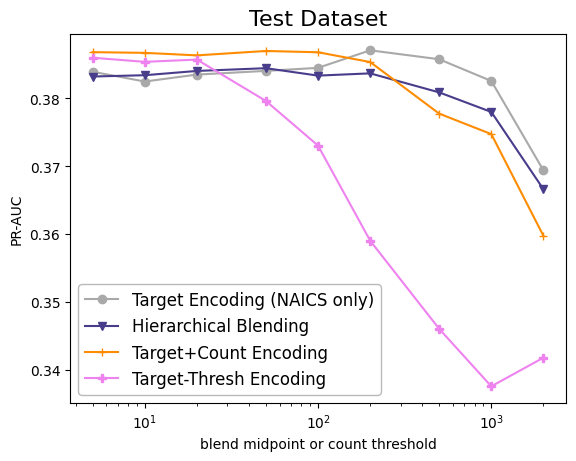

In [20]:
fig = make_plot(metrics_sum_dict, 0, 
                title='Test Dataset')
#plt.gca().legend(frameon=True, fontsize=12).set_bbox_to_anchor((0.9, 0.4))
fig.savefig(Path(setup.temp_path).joinpath('A63_PLOT_compare_base_reg.png'),
            bbox_inches='tight')

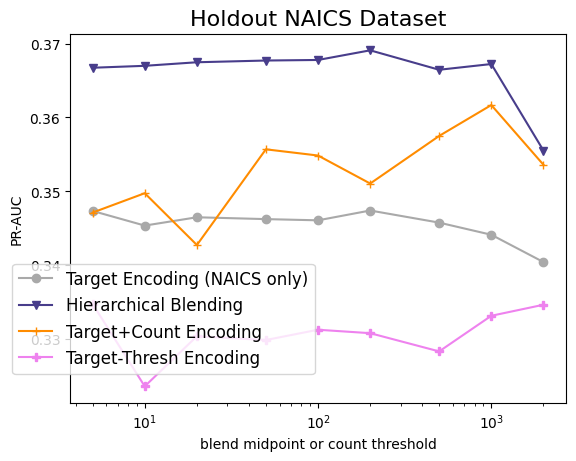

In [21]:
fig = make_plot(metrics_sum_dict, 1, 
                title='Holdout NAICS Dataset')
plt.gca().legend(frameon=True, fontsize=12).set_bbox_to_anchor((0.51, 0.4))
fig.savefig(Path(setup.temp_path).joinpath('A63_PLOT_compare_base_ho.png'),
            bbox_inches='tight')

##### Combined plot

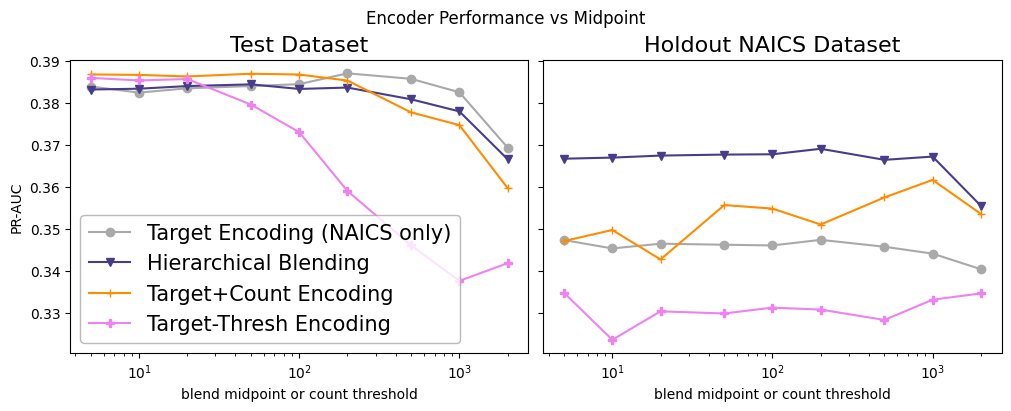

In [22]:
# Combined plot
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True,
                      figsize = (10,4), layout='constrained')
make_plot(metrics_sum_dict, 0, 
                title='Test Dataset',
         ax=ax[0],
         legendsize=15)
make_plot(metrics_sum_dict, 1,
                title='Holdout NAICS Dataset',
         ax=ax[1])
ax[1].legend().set_visible(False)
fig.suptitle('Encoder Performance vs Midpoint')
fig.savefig(Path(setup.temp_path).joinpath('A63_PLOT_compare_base_combined.png'),
            bbox_inches='tight')